<a href="https://colab.research.google.com/github/siddharthdhara/Pytorch-Practice-/blob/main/CV_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Computer Vision
#Two Methods improve model generalization, namely image augmentation and fine tuning

image augmentation -- creates a more diverse dataset i.e. size of training set increases, helping models generalize better and reducing overfitting, i.e. basically performing different operations on the images like flipping, cropping etc.

In [ ]:
!pip install d2l==1.0.3

In [ ]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

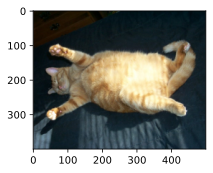

In [ ]:
#Using a 400 x 500 image for image augmentation
d2l.set_figsize()
img = d2l.Image.open('/content/cat1.jpg')
d2l.plt.imshow(img)

In [ ]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
  Y = [aug(img) for _ in range(num_rows * num_cols)]
  d2l.show_images(Y, num_rows, num_cols, scale=scale)

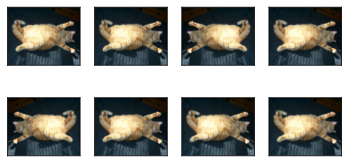

In [ ]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

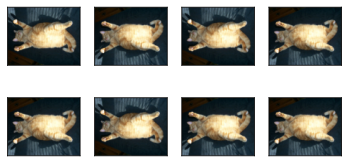

In [ ]:
apply(img, torchvision.transforms.RandomVerticalFlip())

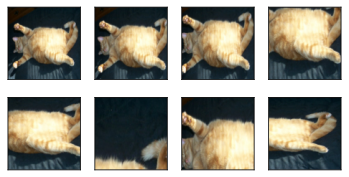

In [ ]:
shape_aug = torchvision.transforms.RandomResizedCrop(
(200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

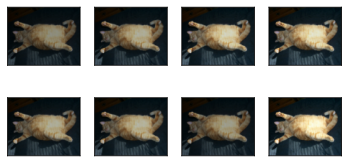

In [ ]:
apply(img, torchvision.transforms.ColorJitter(
brightness=0.5, contrast=0, saturation=0, hue=0))

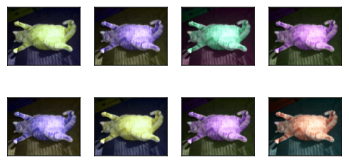

In [ ]:
apply(img, torchvision.transforms.ColorJitter(
brightness=0, contrast=0, saturation=0, hue=0.5))

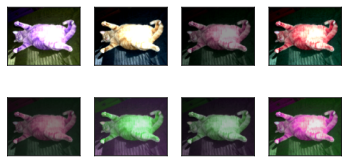

In [ ]:
color_aug = torchvision.transforms.ColorJitter(
brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

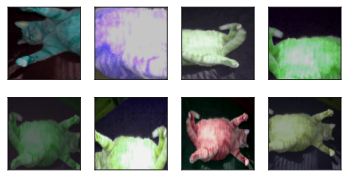

In [ ]:
augs = torchvision.transforms.Compose([
torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

Training a model with Image Augmentation

100%|██████████| 170498071/170498071 [00:05<00:00, 31318425.94it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data


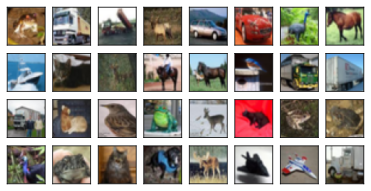

In [ ]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [ ]:
train_augs = torchvision.transforms.Compose([
torchvision.transforms.RandomHorizontalFlip(),
torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
torchvision.transforms.ToTensor()])


In [ ]:
def load_cifar10(is_train, augs, batch_size):
  dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train, transform=augs, download=True)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=is_train, num_workers=d2l.get_dataloader_workers())
  return dataloader

In [ ]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
  if isinstance(X, list):
    X = [x.to(devices[0]) for x in X]
  else:
    X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [ ]:
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices=d2l.try_all_gpus()):
  timer, num_batches = d2l.Timer(), len(train_iter)
  animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1], legend=['train loss', 'train acc', 'test acc'])
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  for epoch in range(num_epochs):
    metric = d2l.Accumulator(4)
    for i, (features, labels) in enumerate(train_iter):
      timer.start()
      l, acc = train_batch_ch13(net, features, labels, loss, trainer, devices)
      metric.add(l, acc, labels.shape[0], labels.numel())
      timer.stop()
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[2], metric[1] / metric[3],None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        print(f'loss {metric[0] / metric[2]:.3f}, train acc 'f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
        print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on 'f'{str(devices)}')

batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)
net.apply(d2l.init_cnn)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
  train_iter = load_cifar10(True, train_augs, batch_size)
  test_iter = load_cifar10(False, test_augs, batch_size)
  loss = nn.CrossEntropyLoss(reduction="none")
  trainer = torch.optim.Adam(net.parameters(), lr=lr)
  net(next(iter(train_iter))[0])
  train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


loss 0.200, train acc 0.931, test acc 0.814
1119.0 examples/sec on [device(type='cuda', index=0)]


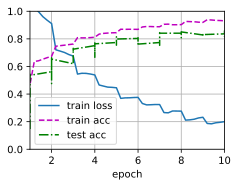

In [ ]:
train_with_data_aug(train_augs, test_augs, net)

Fine-Tuning --- tweaking a trained model to make it work better for a new task without starting all over again.

In [ ]:
#Transfer learning is a method to transfer data from source dataset to target dataset.
#fine tuning is a common technique in transfer learning

#1. Pretraining a NN Model - source model
#2. Create a new NN model - target model - copies everything except the output layer
#3. Add an o/p layer to target model
#4. Train the target model on the target dataset

In [ ]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [ ]:
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip','fba480ffa8aa7e0febbb511d181409f899b9baa5')
data_dir = d2l.download_extract('hotdog')

In [ ]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

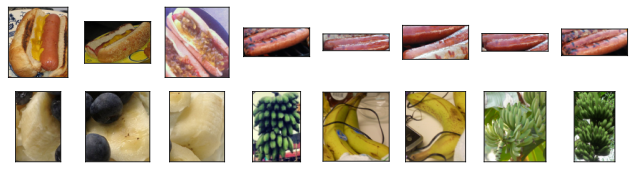

In [ ]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

In [ ]:
# Specify the means and standard deviations of the three RGB channels to
# standardize each channel
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([torchvision.transforms.RandomResizedCrop(224), torchvision.transforms.RandomHorizontalFlip(),
                                             torchvision.transforms.ToTensor(),normalize])
test_augs = torchvision.transforms.Compose([torchvision.transforms.Resize([256, 256]),torchvision.transforms.CenterCrop(224),
                                            torchvision.transforms.ToTensor(),normalize])


In [ ]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 102MB/s]


In [ ]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);

In [ ]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

loss 0.194, train acc 0.931, test acc 0.949
330.5 examples/sec on [device(type='cuda', index=0)]


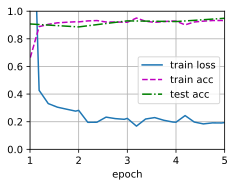

In [ ]:
train_fine_tuning(finetune_net, 5e-5)

loss 0.351, train acc 0.845, test acc 0.844
321.2 examples/sec on [device(type='cuda', index=0)]


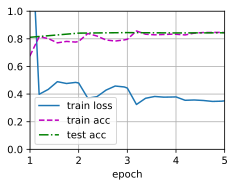

In [ ]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

Object Detection/Recognition and Bounding Boxes (rectangles drawn around objects in images to highlight their location i.e. describes the spatial location of an object i.e. x and y coordinates)

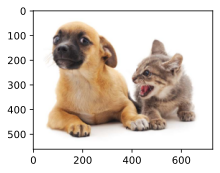

In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

d2l.set_figsize()
img = d2l.Image.open('/content/catdog.jpg')
d2l.plt.imshow(img);


In [ ]:
def box_corner_to_center(boxes):
  x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
  cx = (x1 + x2) / 2
  cy = (y1 + y2) / 2
  w = x2 - x1
  h = y2 - y1
  boxes = torch.stack((cx, cy, w, h), axis=-1)
  return boxes

In [ ]:
def box_center_to_corner(boxes):
  cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
  x1 = cx - 0.5 * w
  y1 = cy - 0.5 * h
  x2 = cx + 0.5 * w
  y2 = cy + 0.5 * h
  boxes = torch.stack((x1, y1, x2, y2), axis=-1)
  return boxes

In [ ]:
# Here `bbox` is the abbreviation for bounding box
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

In [ ]:
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes


tensor([[True, True, True, True],
        [True, True, True, True]])

In [ ]:
def bbox_to_rect(bbox, color):
  return d2l.plt.Rectangle(
      xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1], fill=False, edgecolor=color, linewidth=2)

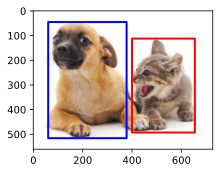

In [ ]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

**Multiscale object detection** -- Finding and identifying objects in images at different sizes or scales, ensuring accuracy across various object dimensions.

**multiscale anchor boxes** -- Predefined boxes of different sizes used to detect objects at various scales in an image. These boxes help algorithms identify objects of different sizes and shapes.

**Multiscale Anchor Boxes**

In [ ]:
%matplotlib inline
import torch
from PIL import Image
from d2l import torch as d2l


In [ ]:
img=d2l.Image.open('/content/catdog.jpg')
h,w=img.size
h,w

(728, 561)

In [ ]:
def display_anchors(fmap_w, fmap_h, s):
    d2l.set_figsize()
    # Values on the first two dimensions do not affect the output
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = d2l.multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))
    d2l.show_bboxes(d2l.plt.imshow(img).axes,
                    anchors[0] * bbox_scale)

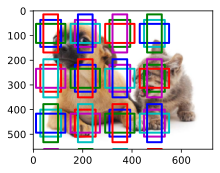

In [ ]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

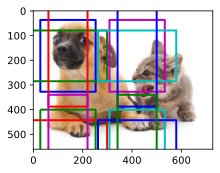

In [ ]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

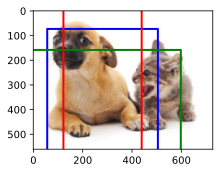

In [ ]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])

**Object Detection Dataset** - considering a small banana dataset just to show object detection from various pictures of a dataset

In [ ]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

d2l.DATA_HUB['banana-detection'] = (    d2l.DATA_URL + 'banana-detection.zip',    '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [ ]:
#reading the dataset

def read_data_bananas(is_train=True):
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [ ]:
#BananasDataset class will allow us to create a customized Dataset instance for loading the banana detection dataset

class BananasDataset(torch.utils.data.Dataset):
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [ ]:
#load_data_bananas function returns two data iterator instances for both the training and test sets

def load_data_bananas(batch_size):
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),batch_size)
    return train_iter, val_iter

In [ ]:
#minibatch
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

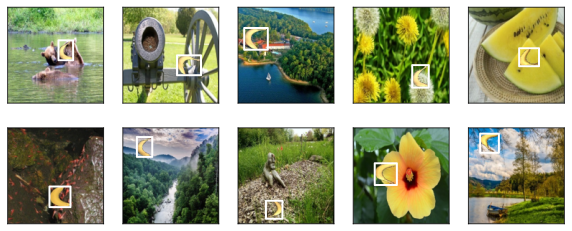

In [ ]:
#demonstration of the working of the object detection algorithm

imgs = (batch[0][:15].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])